##                                   Internal Microsoft Use Only

In [1]:
#importing the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, make_scorer, f1_score, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

Using TensorFlow backend.
/Users/simonyanaleksandr/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/simonyanaleksandr/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# reading the data
data = pd.read_csv('upwork_data_0.csv') # Loading in the data dictionary

In [3]:
# Transforming the target variable to either 0 or 1
data['y'] =  data['over_50k'].map({'<=50K': 0, '>50K': 1})

In [4]:
# splitting the data (whether the target variable is known or not)
data_missing_target = data[data['y'].isnull()]

In [5]:
# data with known target variable
data_c = data[data['y'].notna()]

In [6]:
# replacing nulls and catching unknown instances of the data, such as "?"
data_c = data_c.replace(-1, 0)
data_c = data_c.replace('?', 0)
data_c= data_c.fillna(0)


In [7]:
# droping 'over_50k columnn , since we already have y as a target
data_c.drop(['over_50k'], axis =1, inplace = True)

In [8]:
# Function for quick analysis (calculates correlation, missing ration, nulls, kurtosis and other useful metrics)
def analyzer(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [9]:
analyzer(data_c, pred = 'y')

Data shape: (26934, 15)
___________________________
Data types:
 object     8
int64      6
float64    1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr y
id,int64,26934,26114,0,0.0,"[[12106, 28951, 24570, 16358, 9375, 10738, 207...",-0.002876,-1.199608,0.002151
age,int64,26934,68,0,0.0,"[[32, 43, 35, 31, 64, 55, 41, 39, 60, 62, 0, 2...",-0.301261,0.162294,0.201880
workclass,object,26934,9,0,0.0,"[[Private, State-gov, 0, Local-gov, Self-emp-n...",NaN,NaN,NaN
education,object,26934,17,0,0.0,"[[HS-grad, Some-college, 0, 10th, Bachelors, M...",NaN,NaN,NaN
education_num,int64,26934,16,0,0.0,"[[9, 10, 14, 13, 6, 12, 8, 3, 7, 11, 5, 2, 4, ...",-0.431650,1.236391,0.045722
marital_status,object,26934,7,0,0.0,"[[Divorced, Married-civ-spouse, Never-married,...",NaN,NaN,NaN
occupation,object,26934,15,0,0.0,"[[Adm-clerical, Exec-managerial, Prof-specialt...",NaN,NaN,NaN
relationship,object,26934,6,0,0.0,"[[Other-relative, Unmarried, Wife, Not-in-fami...",NaN,NaN,NaN
race,object,26934,6,0,0.0,"[[W hite, White, Black, Asian-Pac-Islander, Ot...",NaN,NaN,NaN
sex,object,26934,2,0,0.0,"[[Female, Male]]",NaN,NaN,NaN


In [10]:
#looking for duplicates
data_c[data_c.duplicated(keep='last')]

,id,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,y
27,10883,30,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1848,40,United-States,1.0
30,19710,58,Self-emp-not-inc,10th,6,Married-civ-spouse,Craft-repair,Wife,White,Female,0,1977,35,0,1.0
34,30003,0,Private,11th,7,Never-married,Prof-specialty,Own-child,White,Female,0,0,2,United-States,0.0
53,26788,33,Federal-gov,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.0
55,222,64,0,1st-4th,2,Divorced,0,Not-in-family,W hite,Male,0,0,40,United-States,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27490,20772,23,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States,0.0
27855,17765,52,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,1.0
28660,11459,31,Private,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,0.0
28831,13765,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Female,0,0,40,United-States,0.0


In [11]:
#droping the doulicates
data_c =  data_c.drop_duplicates()

In [12]:
#still we can see that the data has duplicate id-s, even though there are no duplicate rows right
data_c['id'][data_c['id'].duplicated(keep='last')]

9        24794
118      14319
198      18792
343      19035
347      23317
         ...  
25736       22
25977    12440
27318    11874
27714    17235
28829    19394
Name: id, Length: 163, dtype: int64

In [13]:
#drop the rows with duplicate ids
data_c.drop_duplicates('id', inplace=True)

### Data Exploration

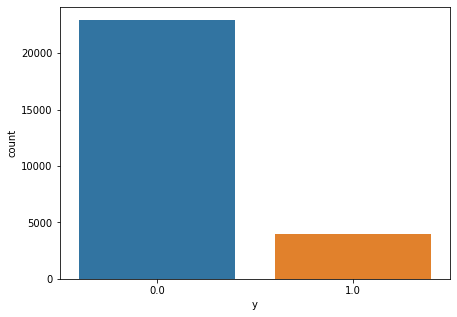

In [14]:
## we can see the data is highly inbalanced (we will need to use syntetic sampling techniques in model selection part)
plt.figure(figsize = (7,5))
sns.countplot(data['y'])

(array([2807.,    0., 3611., 6324., 5493., 4024., 2452., 1020.,  300.,
          83.]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <a list of 10 Patch objects>)

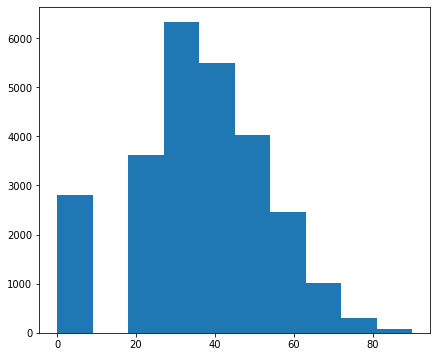

In [15]:
## age distribution (we can see that taking 0 as a missing value is illogical, we should replace 0 with mean)
plt.figure(figsize = (7,6))
plt.hist(data_c['age'])

In [16]:
average_age =  data_c['age'].mean()

In [17]:
# replacing 0 wit mean
data_c['age'] =  data_c['age'].replace(0, average_age)

(array([5073., 4862., 7201., 3511., 2248., 1816.,  894.,  347.,  111.,
          51.]),
 array([22. , 28.8, 35.6, 42.4, 49.2, 56. , 62.8, 69.6, 76.4, 83.2, 90. ]),
 <a list of 10 Patch objects>)

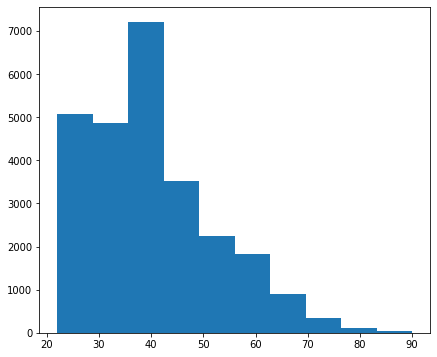

In [18]:
plt.figure(figsize = (7,6))

plt.hist(data_c['age'])

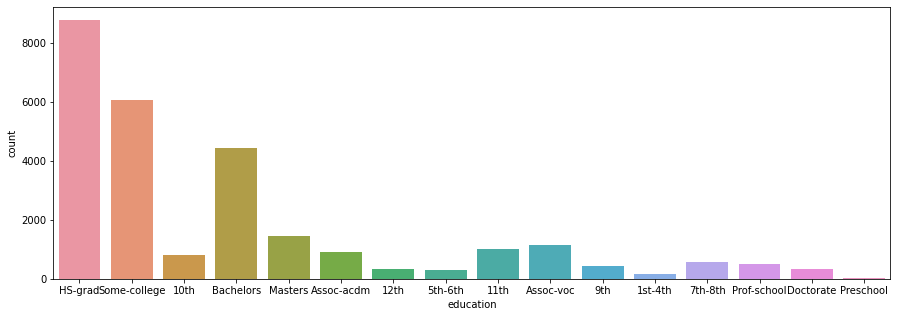

In [19]:
# education distribution
plt.figure(figsize = (15,5))
sns.countplot(data['education'])

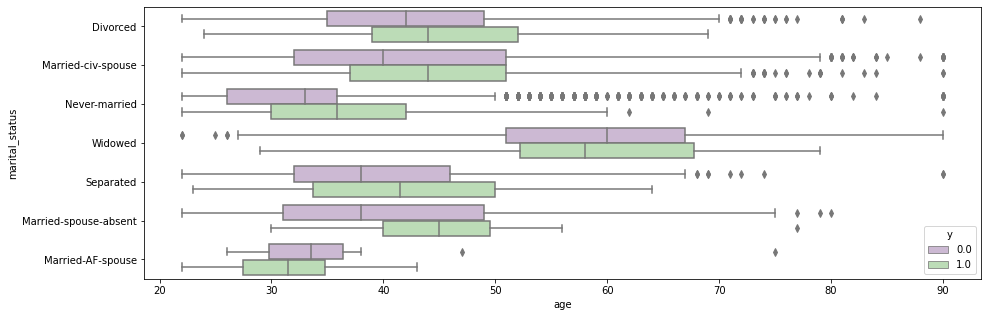

In [20]:
#relationship between martial status, age and target 
plt.figure(figsize = (15,5))
sns.boxplot(data = data_c ,  x  = 'age', y = 'marital_status', hue = 'y', color = 'r', palette= 'PRGn')

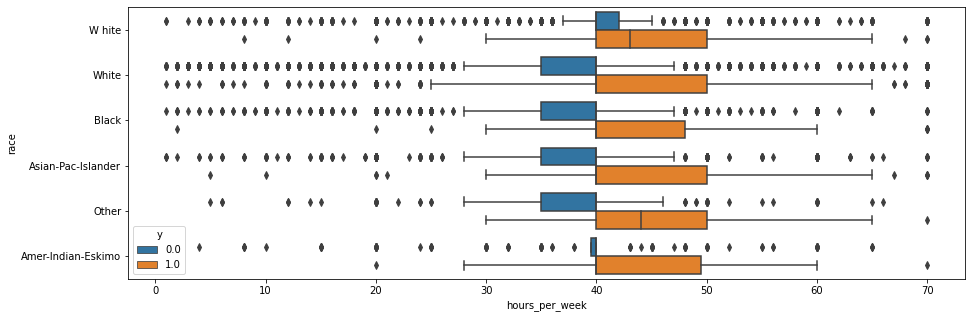

In [21]:
# relationship between race, hourse per week  and target (we can clearly see how hourse per week impacts the target)
# also we can see that we have to replace "W hite" with "White"
plt.figure(figsize = (15,5))
sns.boxplot(data = data_c[data_c['hours_per_week'] <= 70] ,  x  = 'hours_per_week', y = 'race', hue = 'y')

In [22]:
#replacing W hite" with "White"
data_c = data_c.replace('W hite', 'White')

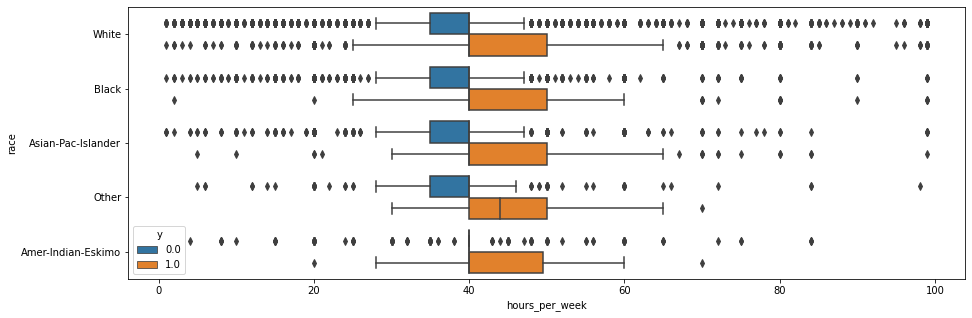

In [23]:

plt.figure(figsize = (15,5))
sns.boxplot(data = data_c[data_c['hours_per_week'] <= 100] ,  x  = 'hours_per_week', y = 'race', hue = 'y')

In [24]:
data_c = data_c[data_c['hours_per_week'] <= 100]

In [25]:
data_c

,id,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,y
0,12106,32.00000,Private,HS-grad,9,Divorced,Adm-clerical,Other-relative,White,Female,0,0,40,United-States,0.0
1,28951,43.00000,State-gov,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0.0
2,24570,35.00000,Private,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,1.0
3,16358,31.00000,Private,0,14,Never-married,Prof-specialty,Not-in-family,Black,Male,0,0,40,United-States,0.0
4,9375,64.00000,Private,Some-college,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,10566,0,35,United-States,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30199,8517,35.81711,Private,9th,5,Never-married,Sales,Own-child,Other,Female,0,0,32,United-States,0.0
30200,20082,56.00000,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,4508,0,40,United-States,0.0
30201,547,58.00000,Private,10th,6,Married-civ-spouse,Other-service,Wife,White,Female,0,0,8,United-States,0.0
30202,28777,39.00000,Private,0,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1.0


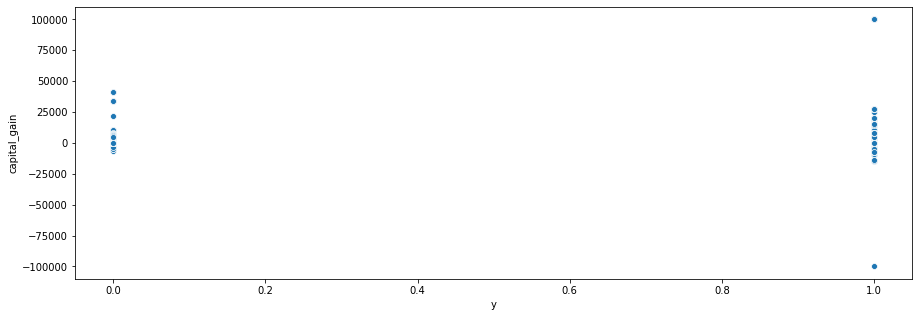

In [26]:
#capital gain and target (more variation, more likely earn more than 50k)
plt.figure(figsize = (15,5))
sns.scatterplot(data_c['y'], data_c['capital_gain'])

In [27]:
data_c = data_c[data_c['capital_gain'] <= 75000]

In [28]:
data_c = data_c[data_c['capital_loss'] >= 0]

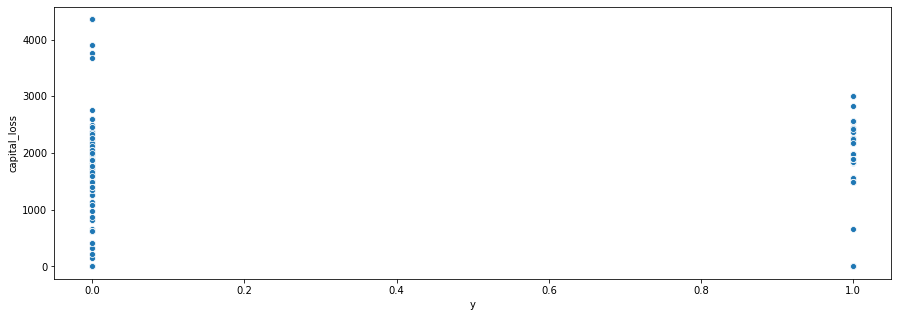

In [29]:
## capital loss and target (less variation, more likely earn more than 50k)

plt.figure(figsize = (15,5))

sns.scatterplot(data_c['y'], data_c['capital_loss'] )

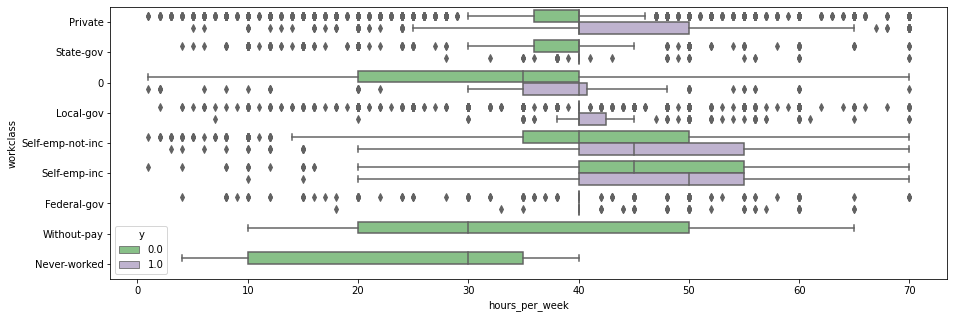

In [30]:
## relationship between work class, target, and hours per week
plt.figure(figsize = (15,5))
sns.boxplot(data = data_c[data_c['hours_per_week'] <= 70] ,  x  = 'hours_per_week', y = 'workclass', hue = 'y', palette= 'Accent')

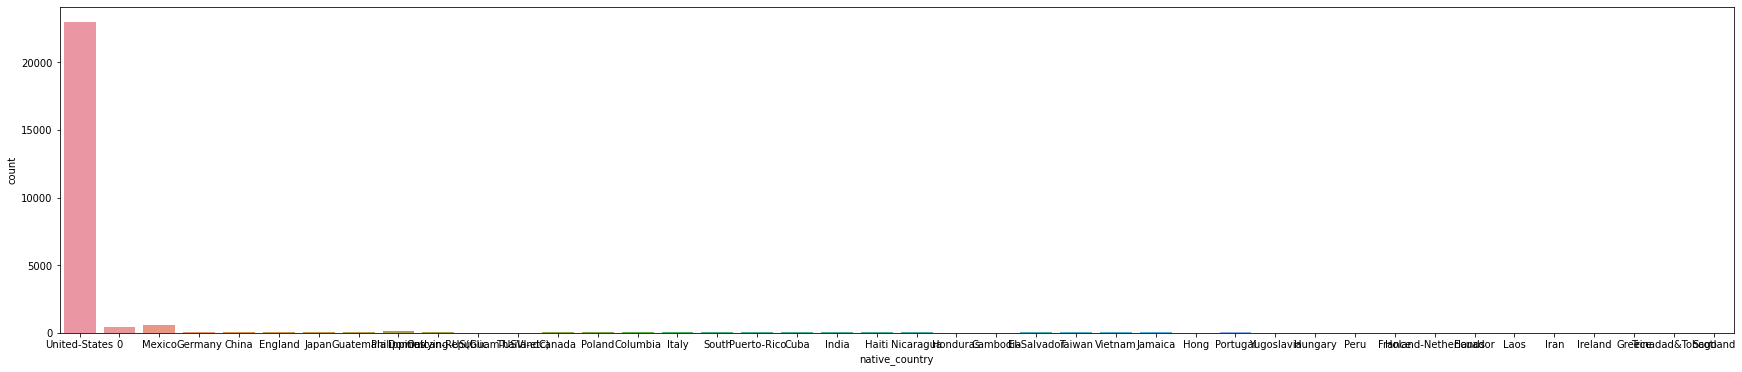

In [31]:
## country distribution (it is useless to keep all those small countries, it is better to split between US and other countries)
plt.figure(figsize = (30,6))
sns.countplot(data_c['native_country'])

In [32]:
## splitting between US and other countries
col         = 'native_country'
conditions  = [ data_c[col] == 'United-States', data_c[col] != 'United-States']
choices     = [ 'United-States', 'RestWorld' ]

In [33]:
## done
data_c["country"] = np.select(conditions, choices, default=np.nan)

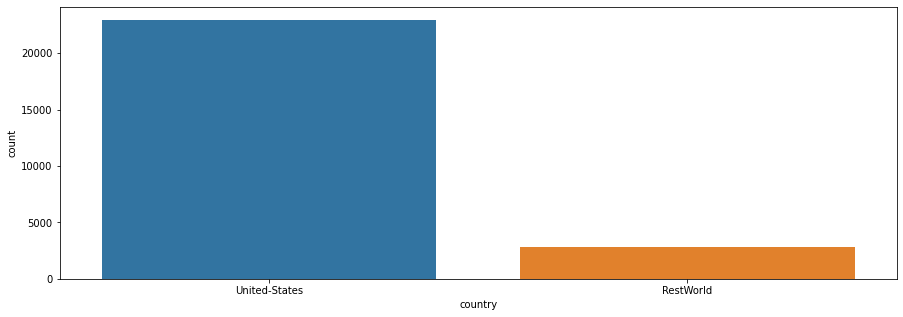

In [34]:
## US vs restworld
plt.figure(figsize = (15,5))

sns.countplot(data_c['country'])

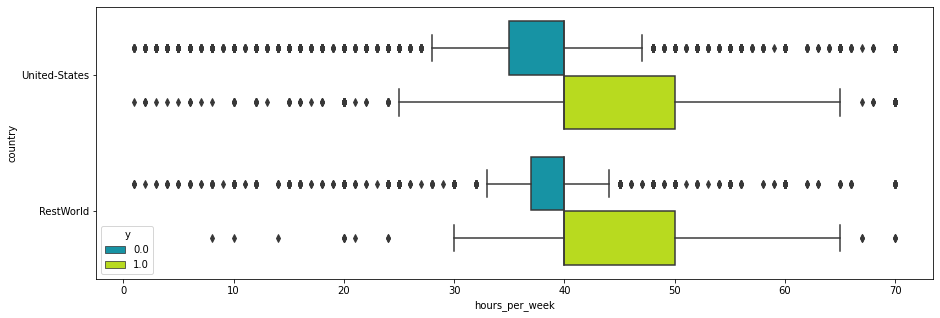

In [35]:
##country, hours and target (there is no signifcant impact of country on earnings, though Rest World is more likely to getover 50K)
plt.figure(figsize = (15,5))

sns.boxplot(data = data_c[data_c['hours_per_week'] <= 70] ,  x  = 'hours_per_week', y = 'country', hue = 'y', palette= 'nipy_spectral')

In [36]:
## Now we have our cleaned and validation data
data_c.to_csv("cleaned_training_data.csv")

### Model selection

In [37]:
data_c.drop(['native_country'], axis =1, inplace = True)

In [38]:
## Taking target and independet variables
X = data_c.drop(['y'], axis =1)

In [39]:
y = data_c['y']

In [40]:
X = pd.get_dummies(X)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [42]:
## taking various standard ml model, let's which will perform the berst
clf_lr  = LogisticRegression(solver='lbfgs', random_state=0, max_iter=1000)
clf_rf  = RandomForestClassifier(random_state=0)
clf_svc = SVC(random_state=0)
clf_knn = KNeighborsClassifier()
xgb =XGBClassifier()

In [43]:
clf_lr.fit(X_train,y_train)

/Users/simonyanaleksandr/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
predictions =  clf_lr.predict(X_test)

In [45]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.93      4767
         1.0       0.30      0.59      0.40       387

    accuracy                           0.87      5154
   macro avg       0.63      0.74      0.66      5154
weighted avg       0.91      0.87      0.89      5154



In [46]:
clf_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [47]:
predictions =  clf_rf.predict(X_test)

In [234]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93      4665
         1.0       0.42      0.64      0.51       489

    accuracy                           0.88      5154
   macro avg       0.69      0.77      0.72      5154
weighted avg       0.91      0.88      0.89      5154



In [235]:
clf_svc.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [236]:
predictions =  clf_svc.predict(X_test)

In [ ]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      5041
         1.0       0.13      0.87      0.23       113

    accuracy                           0.87      5154
   macro avg       0.56      0.87      0.58      5154
weighted avg       0.98      0.87      0.91      5154



In [ ]:
### Random forest classifier performed the best, looks like we have to use tree based models. It is time to use extreme gradient boosting model to achhieve best results

In [ ]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
predictions =  xgb.predict(X_test)

In [ ]:
## we see that we have good enough score, since accuracy and macro average are descent but science data is highly inbalanced the model
## model works poorly on identifying 1 instances of class
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      4857
         1.0       0.31      0.79      0.44       297

    accuracy                           0.89      5154
   macro avg       0.65      0.84      0.69      5154
weighted avg       0.95      0.89      0.91      5154



In [ ]:
## we will tune the parametrs to achieve better results
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [ ]:
## loop over the parametrs
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
##applying gridsearch to get the data
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 5,
    cv = 5,
    verbose=True
)

In [ ]:
grid_search.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [ ]:
## here are the best estimators (nore that we still have to change base score and apply sampling technique)
grid_search.best_estimator_

In [48]:
xgb = XGBClassifier(
    base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1
)

In [49]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [50]:
predictions =  xgb.predict(X_test)

In [45]:
## performance enhanced significantly
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.93      4767
         1.0       0.30      0.59      0.40       387

    accuracy                           0.87      5154
   macro avg       0.63      0.74      0.66      5154
weighted avg       0.91      0.87      0.89      5154



In [46]:
## Syntetic sampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [47]:
## fiting the data
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [48]:
## new xgboost with syntetic sampling
xgb = XGBClassifier(
    base_score=0.94, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
     
    learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=220, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1
)

In [49]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.94, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=220, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [50]:
predictions =  xgb.predict(X_test)

In [52]:
## we see that simple logistic regression produced weighted average score of 0.62 now we have a descent score of 0.77%
## also our accuracy is very high 0.90% looks like the model is doing good job
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      4577
         1.0       0.53      0.69      0.60       577

    accuracy                           0.90      5154
   macro avg       0.74      0.80      0.77      5154
weighted avg       0.91      0.90      0.90      5154



# Applying classifier on unkown data that missed target in the beginning

In [56]:
##droping the target
data_missing_target = data_missing_target.drop(['over_50k', 'y'], axis =1 )

In [57]:
## replacing missing as we did previosly
data_missing_target = data_missing_target.replace(-1, 0)
data_missing_target= data_missing_target.replace('?', 0)
data_missing_target= data_missing_target.fillna(0)

In [58]:
## chaning the country to US and rest world
col         = 'native_country'
conditions  = [ data_missing_target[col] == 'United-States', data_missing_target[col] != 'United-States']
choices     = [ 'United-States', 'RestWorld' ]

In [59]:
data_missing_target["country"] = np.select(conditions, choices, default=np.nan)

In [60]:
## changing average age
average_age =   data_missing_target['age'].mean()
data_missing_target['age'] =  data_missing_target['age'].replace(0, average_age)

In [61]:
## replacing W hite to White
data_missing_target = data_missing_target.replace('W hite', 'White')

In [62]:
## droping native_country
data_missing_target = data_missing_target.drop(['native_country'], axis =1 )

In [63]:
##droping duplicates
data_missing_target =  data_missing_target.drop_duplicates()

In [64]:
##droping duplicate ids
data_missing_target['id'][data_missing_target['id'].duplicated(keep='last')]




757      32439
2313     18194
3186      4984
3722     24557
4597     19862
5930     12395
5958      9633
8748     16871
9409     11754
11230     3106
11551    23192
12065    20485
12184    27213
12879    12716
13025    23304
13134     3112
14481    14143
15423     8539
18794    21190
24781     6008
Name: id, dtype: int64

In [65]:
#inplacing ids
data_missing_target.drop_duplicates('id', inplace=True)

In [66]:
## selecting features
X_pred =  data_missing_target

In [67]:
## creating the dummies
X_pred =  pd.get_dummies(X_pred)

In [68]:
data_missing_target

,id,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country
33,28244,34,Federal-gov,Bachelors,13,Married-civ-spouse,Protective-serv,Husband,White,Male,0,1902,48,United-States
60,17211,41,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
70,3888,31,0,Bachelors,13,Married-civ-spouse,0,Wife,White,Female,0,0,25,United-States
71,22229,56,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States
79,32186,52,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30172,30402,37,Local-gov,Masters,14,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,45,United-States
30180,30193,32,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,48,United-States
30183,15580,61,0,Bachelors,13,Married-civ-spouse,0,Husband,White,Male,0,0,40,United-States
30186,3225,57,Self-emp-not-inc,Prof-school,15,Married-civ-spouse,Sales,Wife,White,Female,15024,0,35,United-States


In [69]:
## now we need to match all our columns to the columns of our vaildation set so that our model works
missing_cols = set( X.columns ) - set(X_pred.columns )

In [70]:
for ting in X_pred.columns[~X_pred.columns.isin(X.columns)]:
     X_pred[ting] = 0

In [71]:
for i in missing_cols:
    X_pred[i] = 0

In [72]:
##loop create all the column that we miss  and fills them with 0-s
missing_cols = set( X.columns ) - set( X_pred.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_pred = X_pred[X.columns]

In [73]:
X_pred

,id,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_0,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,country_RestWorld,country_United-States
33,28244,34,13,0,1902,48,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
60,17211,41,13,0,0,50,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
70,3888,31,13,0,0,25,1,0,0,0,...,1,0,0,0,0,1,1,0,0,1
71,22229,56,13,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
79,32186,52,13,0,0,50,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30172,30402,37,14,0,0,45,0,0,1,0,...,1,0,0,0,0,1,1,0,0,1
30180,30193,32,13,0,0,48,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
30183,15580,61,13,0,0,40,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1
30186,3225,57,15,15024,0,35,0,0,0,0,...,1,0,0,0,0,1,1,0,0,1


In [74]:
## making our predictions
predictions  =  pd.DataFrame(xgb.predict(X_pred))

In [75]:
##reseting index
data_missing_target =  data_missing_target.reset_index()

In [76]:
##mering the data
final_data =  pd.concat([data_missing_target, predictions], axis =1)

In [77]:
final_data

,index,id,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,0
0,33,28244,34,Federal-gov,Bachelors,13,Married-civ-spouse,Protective-serv,Husband,White,Male,0,1902,48,United-States,0.0
1,60,17211,41,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,0.0
2,70,3888,31,0,Bachelors,13,Married-civ-spouse,0,Wife,White,Female,0,0,25,United-States,0.0
3,71,22229,56,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,0.0
4,79,32186,52,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186,30172,30402,37,Local-gov,Masters,14,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,45,United-States,0.0
3187,30180,30193,32,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,48,United-States,0.0
3188,30183,15580,61,0,Bachelors,13,Married-civ-spouse,0,Husband,White,Male,0,0,40,United-States,0.0
3189,30186,3225,57,Self-emp-not-inc,Prof-school,15,Married-civ-spouse,Sales,Wife,White,Female,15024,0,35,United-States,1.0


In [78]:
final = final_data[['id',0 ]]

In [79]:
###id and target
final.columns = ['id', 'target']

In [80]:
## csv is ready
final.to_csv("predictions.csv")

In [83]:
final_data = final_data.drop([ 'index'], axis=1 )

In [84]:
final_data.columns = data_c.columns

In [85]:
data_c.columns = ['id', 'age','workclass', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'target', 'country']





In [86]:
final_data.columns = ['id', 'age','workclass', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']


In [87]:
data_c.to_csv("data_for_training_and_evaluation.csv")

In [88]:
frames = [data_c, final_data]

In [89]:
 result = pd.concat(frames)

In [90]:
##final_Csv
result.to_csv("final_cleaned_data.csv")